In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from torchvision import transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import numpy as np
import os

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [ ]:
batch_size = 16
image_size = 64

# Create the dataset
anime_faces_dataset = datasets.ImageFolder(
    root=os.path.join(os.getcwd(), 'data', 'anime-class'),
    transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),  # Crop out the center to get 64x64 images
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
)

In [11]:
classes = anime_faces_dataset.classes

classes

['bad_fake_images', 'real_images']

In [ ]:
train_set, test_set = data.random_split(anime_faces_dataset, [1640, 408])

In [13]:
trainloader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

In [16]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
images.shape

torch.Size([16, 3, 64, 64])

bad_fake_images real_images bad_fake_images real_images bad_fake_images real_images real_images real_images bad_fake_images bad_fake_images real_images real_images bad_fake_images real_images real_images bad_fake_images


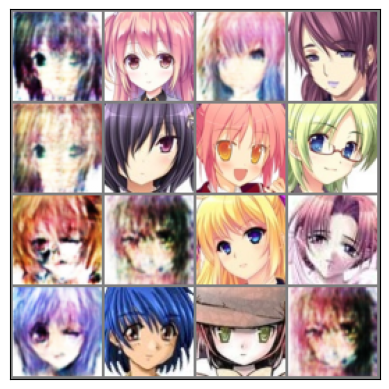

In [17]:
def display(img):
    img = img / 2 + 0.5  # unnormalize
    img = img.permute(1, 2, 0)  # change from (C, H, W) to (H, W, C)
    npimg = img.numpy()

    plt.imshow(npimg)
    plt.xticks([])
    plt.yticks([])
    plt.show()

print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

display(make_grid(images, nrow=4))


In [18]:
# Number of channels in the training images.
nc = 3

# Size of the feature maps in the discriminator.
ndf = 64

# Learning rate for optimizers
lr = 0.0002

In [22]:
def weight_init(m):
    classname = m.__class__.__name__

    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [29]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            # Input is (nc) x 64 x 64
            nn.Conv2d(
                in_channels=nc,
                out_channels=ndf,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.LeakyReLU(0.2, inplace=True), # Shows to improve the performance of the discriminator

            # State size: (ndf) x 32 x 32
            nn.Conv2d(
                in_channels=ndf,
                out_channels=ndf * 2,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(ndf * 2), # Normalizes the output of the previous layer to have mean 0 and variance 1 Helps mitigate problems
            nn.LeakyReLU(0.2, inplace=True),

            # State size: (ndf*2) x 16 x 16
            nn.Conv2d(
                in_channels=ndf * 2,
                out_channels=ndf * 4,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # State size: (ndf*4) x 8 x 8
            nn.Conv2d(
                in_channels=ndf * 4,
                out_channels=ndf * 8,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            # State size: (ndf*8) x 4 x 4
            nn.Conv2d(
                in_channels=ndf * 8,
                out_channels=1,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=False
            ),
            nn.Sigmoid()  # Output is between 0 and 1
        )

    def forward(self, x):
        return self.main(x)


In [30]:
netD = Discriminator().to(device)
netD.apply(weight_init)

print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [31]:
criterion = nn.BCELoss() # Binary Cross Entropy Loss

optimizer = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999)) # Adaptive learning rate optimizer

In [32]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = netD(inputs)

        loss = criterion(outputs.flatten(), labels.float())

        # Backward pass and optimize
        loss.backward() # Compute gradients
        optimizer.step() # Update weights

        # Print statistics
        running_loss += loss.item()
        if i % 20 == 0:    # Print every 20 mini-batches
            print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 20:.3f}')
            running_loss = 0.0

print('Finished Training')

[Epoch 1, Batch 1] loss: 0.039
[Epoch 1, Batch 21] loss: 0.103
[Epoch 1, Batch 41] loss: 0.064
[Epoch 1, Batch 61] loss: 0.010
[Epoch 1, Batch 81] loss: 0.004
[Epoch 1, Batch 101] loss: 0.001
[Epoch 2, Batch 1] loss: 0.000
[Epoch 2, Batch 21] loss: 0.000
[Epoch 2, Batch 41] loss: 0.000
[Epoch 2, Batch 61] loss: 0.000
[Epoch 2, Batch 81] loss: 0.000
[Epoch 2, Batch 101] loss: 0.000
Finished Training


GroundTruth:  bad_fake_images bad_fake_images real_images bad_fake_images real_images bad_fake_images real_images bad_fake_images


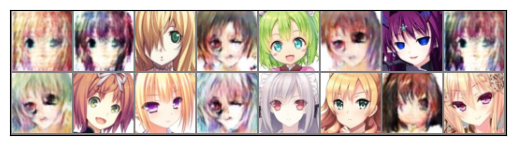

bad_fake_images real_images real_images bad_fake_images real_images real_images bad_fake_images real_images


In [35]:
dataiter = iter(testloader)

images, labels = next(dataiter)

print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))
display(make_grid(images, 8))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(8, 16)))

In [ ]:
outputs = netD(images.to(device))

Predicted:  bad_fake_images bad_fake_images real_images bad_fake_images real_images bad_fake_images real_images bad_fake_images


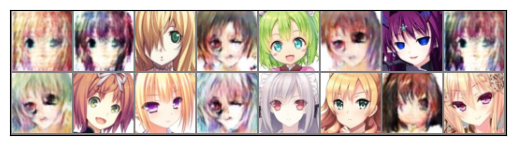

Predicted:  bad_fake_images real_images real_images bad_fake_images real_images real_images bad_fake_images real_images


In [38]:
predicted = torch.round(outputs.flatten())

print('Predicted: ', ' '.join(f'{classes[predicted.long()[j]]:5s}' for j in range(8)))
display(make_grid(images, 8))
print('Predicted: ', ' '.join(f'{classes[predicted.long()[j]]:5s}' for j in range(8, 16)))


In [39]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        outputs = netD(images).flatten()
        predicted = torch.round(outputs).long()

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {total} test images: {100 * correct / total:.2f}%')

Accuracy of the network on the 408 test images: 100.00%
